# APTOS 2019 Blindness Detection
- kaggleのカーネル( https://www.kaggle.com/kernels?sortBy=dateRun&group=profile&pageSize=20  )で作ったデータでしか提出できないコンペだった。。。なので提出できず。。。

#### kaggleカーネルについて
- https://lp-tech.net/articles/kJlwQ
    - スペックは、4core/16GBRAM/連続実行時間60分/1GBのディスク。
    - 無料で使用できる。
    - 情報共有が簡単。
    - pythonとRで使用でき、大抵の機械学習に用いられるモジュールが入っている。
    - dockerを使って実現している。
    - 計算リソースは全てkaggle側がクラウドで提供してくれる。


#### 本notebookのモデル作成参考：https://www.kaggle.com/kmader/attention-inceptionv3-for-blindness

In [1]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util, plot_12task_log, util, set_split
from transformer import get_train_valid_test, my_generator, ndimage
from model import define_model, multi_loss, my_callback, my_metric, my_class_weight 
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict, base_predict, grad_cam_util, visualize_keras_predict#, pr_curve
from tuning import optuna_train_base

import keras
from keras.preprocessing import image

import glob, time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pathlib

%matplotlib inline
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# 75%

output_dir = r'D:\work\kaggle_aptos2019-blindness-detection\work\20190731'
os.makedirs(output_dir, exist_ok=True)

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file
set_split.py: loaded as module file


Using TensorFlow backend.


ndimage.py: loaded as module file
my_generator.py: loaded as module file
get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
my_class_weight.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file
ensemble_predict.py: loaded as module file
base_predict.py: loaded as module file
grad_cam_util.py: loaded as module file
visualize_keras_predict.py: loaded as module file
optuna_train_base.py: loaded as module file


## load data

In [2]:
base_image_dir = os.path.join(r'D:\work\kaggle_aptos2019-blindness-detection\OrigData\aptos2019-blindness-detection')
retina_df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
retina_df['path'] = retina_df['id_code'].map(lambda x: os.path.join(base_image_dir, 'train_images', '{}.png'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

3662 images found of 3662 total


,id_code,diagnosis,path,exists
2736,bda7ff3b1562,2,D:\work\kaggle_aptos2019-blindness-detection\O...,True
690,31360e44ac64,0,D:\work\kaggle_aptos2019-blindness-detection\O...,True
1287,599b89048034,2,D:\work\kaggle_aptos2019-blindness-detection\O...,True


In [37]:
util.ipywidgets_show_img(retina_df['path'])

interactive(children=(IntSlider(value=1830, description='index', max=3661), Output()), _dom_classes=('widget-i…

## Examine the distribution of eye and severity

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B7D48FCB70>]],
      dtype=object)

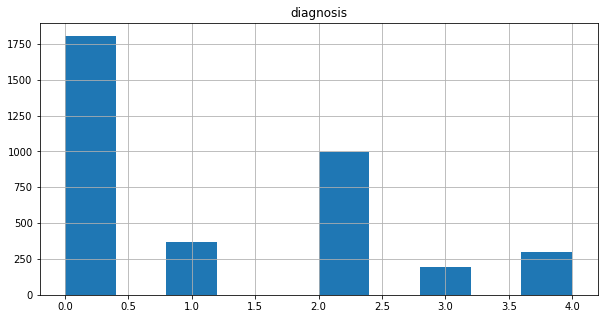

In [48]:
retina_df[['diagnosis']].hist(figsize = (10, 5))

## Split Data into Training and Validation

In [4]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['id_code', 'diagnosis']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['id_code'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['diagnosis'])
raw_train_df = retina_df[retina_df['id_code'].isin(train_ids)]
valid_df = retina_df[retina_df['id_code'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 2746 validation 916


## Balance the distribution in the training set
- over sampling

In [5]:
train_diagnosis_count = raw_train_df.groupby('diagnosis').size()
print(train_diagnosis_count)
train_diagnosis_count.max()

diagnosis
0    1354
1     277
2     749
3     145
4     221
dtype: int64


1354

X.shape y.shape: (2746,) (2746,)
X_resampled.shape y_resampled.shape: (6770, 1) (6770,)
y_resampled.value_counts():
3    1354
2    1354
1    1354
4    1354
0    1354
dtype: int64
(6770,) (6770,)


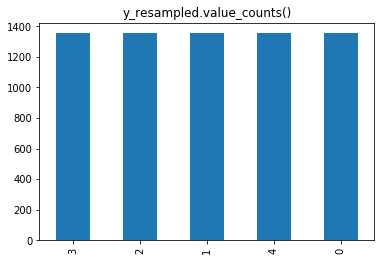

In [6]:
x_paths = raw_train_df['id_code'].values + '.png'
y_ids = raw_train_df['diagnosis'].values
dict_ratio = {  0: train_diagnosis_count.max()
              , 1: train_diagnosis_count.max()
              , 2: train_diagnosis_count.max()
              , 3: train_diagnosis_count.max()
              , 4: train_diagnosis_count.max() }
x_paths, y_ids = get_train_valid_test.imblearn_under_over_sampling(x_paths, y_ids, dict_ratio)
x_paths = x_paths[:,0]
print(x_paths.shape, y_ids.shape)

In [7]:
train_df = pd.DataFrame({'x_paths':x_paths, 'y_ids':y_ids})
train_df['y_ids'] = train_df['y_ids'].astype(str)
display(train_df.head())
print(train_df.shape)
print(train_df.dtypes)

,x_paths,y_ids
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,002c21358ce6.png,0
3,005b95c28852.png,0
4,0083ee8054ee.png,4


(6770, 2)
x_paths    object
y_ids      object
dtype: object


In [8]:
valid_df = pd.DataFrame({'x_paths': valid_df['id_code'].values + '.png', 'y_ids': valid_df['diagnosis'].values})
valid_df['y_ids'] = valid_df['y_ids'].astype(str)
display(valid_df.head())
print(valid_df.shape)
print(valid_df.dtypes)

,x_paths,y_ids
0,0024cdab0c1e.png,1
1,00cb6555d108.png,1
2,00f6c1be5a33.png,0
3,0104b032c141.png,3
4,0124dffecf29.png,1


(916, 2)
x_paths    object
y_ids      object
dtype: object


## param 

In [9]:
num_epoch=500 # epoch数

# optimizer のパラメータ
choice_optim='sgd'#'adabound' # optimizer 
lr=0.01#0.001 # 学習率
#decay=1e-3
momentum=0.9

#choice_model='NASNetLarge'
#trainable=761
#choice_model='InceptionResNetV2'
#trainable=697
choice_model = 'EfficientNet' # fine-tuningモデル
efficientnet_num = 5
layer_name = 'swish_116' # GradCamで切り出す層名
trainable = 564
#choice_model = 'OctConv_WideResNet'
#layer_name = 'activation_53' # GradCamで切り出す層名

FCnum = 0 # 全結合層
trainable = 'all' # 重み学習させる開始層番号
activation = 'softmax' # 出力層の活性化関数

early_stopping=50#20 # 学習打ち切りオプション

### 訓練画像水増しオプション
# ImageDataGenerator
rescale=1.0/255.0
# custom param
mix_up_alpha=0.2# mixup alpha
random_erasing_prob = 0.5 # random_erasing 確率
random_erasing_maxpixel = 255
ricap_beta=0.3 # RICAP beta
ricap_use_same_random_value_on_batch=True # Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」
is_base_aug=True # 下山さんが使っていたAutoAugmentのデフォルト？変換入れるか

# MyImageDataGenerator のオプションを辞書型で詰める
my_IDG_options={'rescale': rescale
                 #, 'horizontal_flip': True
                 , 'vertical_flip': True
                 #, 'zoom_range': [1.0, 1.2]
                 #, 'rotation_range': 20
                 #, 'shear_range': 0.4
                 #, 'channel_shift_range': 20.0
                 #, 'brightness_range': [0.6, 1.2]
                 #, 'random_crop': random_crop
                 , 'mix_up_alpha': mix_up_alpha
                 , 'random_erasing_prob': random_erasing_prob
                 , 'random_erasing_maxpixel': random_erasing_maxpixel
                 #, 'ricap_beta': ricap_beta
                 #, 'ricap_use_same_random_value_on_batch': ricap_use_same_random_value_on_batch
                 , 'is_base_aug': is_base_aug
               }

## data_generator

In [10]:
# flow_from_directory用
batch_size = 6
img_rows, img_cols, channels = 331, 331, 3
data_dir = r'D:\work\kaggle_aptos2019-blindness-detection\OrigData\aptos2019-blindness-detection\train_images'
d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size
                                            , valid_batch_size=batch_size
                                            , train_samples=train_df.shape[0]
                                            , valid_samples=valid_df.shape[0]
                                           )
# class_modeをcategoricalにしてるからラベルをone-hotにしてくれる→だからloss=categorical_crossentropy。
# class_mode指定なしならラベルone-hotじゃないからloss=sparse_categorical_crossentropyにしないとおかしくなる
d_cls.create_my_generator_flow_from_dataframe('x_paths'
                                              , 'y_ids'
                                              , train_df
                                              , data_dir
                                              , valid_df=valid_df
                                              , valid_data_dir=data_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options)
class_name = train_df['y_ids'].unique()
print('class_name:', type(class_name), class_name)

train_steps_per_epoch : 1128
valid_steps_per_epoch : 152
my_IDG_options: {'rescale': 0.00392156862745098, 'vertical_flip': True, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'is_base_aug': True}
Found 916 validated image filenames belonging to 5 classes.
class_name: <class 'numpy.ndarray'> ['2' '4' '0' '1' '3']


color_mode rgb
Found 6770 validated image filenames belonging to 5 classes.
(6, 331, 331, 3)
[[[0.03468506 0.02774805 0.04509058]
  [0.02774805 0.02427954 0.7452138 ]
  [0.03468506 0.02774805 0.04509058]
  ...
  [0.03121655 0.60540322 0.04855908]
  [0.5002777  0.02081104 0.8434023 ]
  [0.26227862 0.02774805 0.04855908]]

 [[0.26227862 0.25881012 0.04855908]
  [0.03121655 0.48987219 0.0554961 ]
  [0.37780966 0.25534161 0.61927725]
  ...
  [0.03468506 0.02774805 0.62274575]
  [0.37780966 0.03121655 0.03815356]
  [0.03468506 0.02774805 0.62274575]]

 [[0.26227862 0.25881012 0.04509058]
  [0.13981058 0.02081104 0.38821518]
  [0.04162207 0.02427954 0.04509058]
  ...
  [0.03815356 0.03121655 0.04855908]
  [0.03468506 0.13981058 0.04855908]
  [0.37780966 0.02774805 0.04509058]]

 ...

 [[0.26921563 0.02774805 0.05202759]
  [0.26921563 0.03121655 0.39515219]
  [0.03468506 0.02774805 0.03815356]
  ...
  [0.03121655 0.48987219 0.27962115]
  [0.25881012 0.02427954 0.04509058]
  [0.03121655 0.0277

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


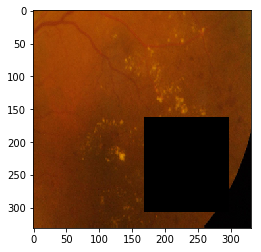

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


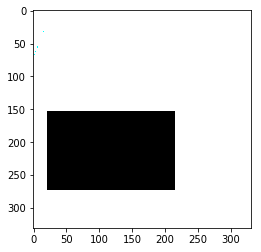

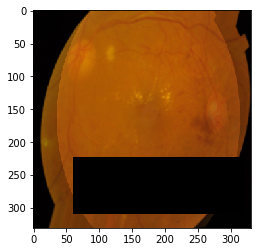

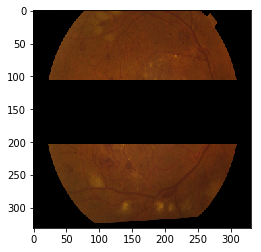

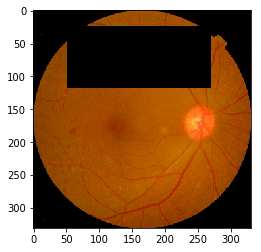

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


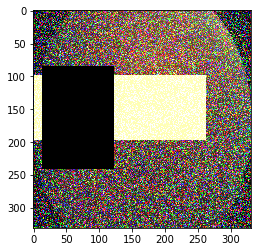

In [11]:
def print_gen(gen, i=0):
    x,y = next(gen)
    print(x.shape)
    print(x[i])
    print(np.max(x))
    print(y.shape)
    print(y[i])
    for ii in range(len(y)):
        plt.imshow(x[ii])
        plt.show()

print_gen(d_cls.train_gen, i=5)

(6, 331, 331, 3)
[[[0.01176471 0.00392157 0.00784314]
  [0.00784314 0.         0.00392157]
  [0.01176471 0.00392157 0.00784314]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.         0.00392157]
  [0.01176471 0.00392157 0.00784314]]

 [[0.01176471 0.00392157 0.00784314]
  [0.01568628 0.00784314 0.01176471]
  [0.01176471 0.00392157 0.00784314]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.         0.00392157]
  [0.01176471 0.00392157 0.00784314]]

 [[0.01176471 0.00392157 0.00784314]
  [0.01176471 0.00392157 0.00784314]
  [0.01176471 0.00392157 0.00784314]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.01176471 0.00392157 0.00784314]
  [0.01176471 0.00392157 0.00784314]]

 ...

 [[0.00784314 0.00784314 0.00784314]
  [0.01176471 0.01176471 0.01176471]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.01176471 0.00392157 0.00784314]
  [0.01176471 0.00392157 0.00784314]
  [0.01176471 0.00392157 0.00784314]]

 [[0.01176471 0.00392157 0.00784314]
  [0.01568628 0.0078

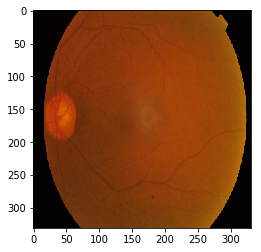

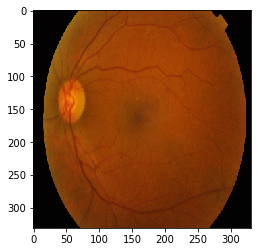

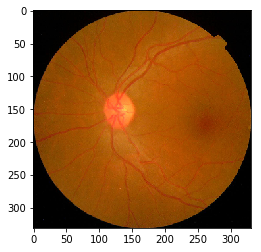

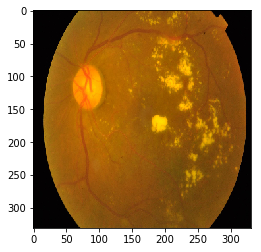

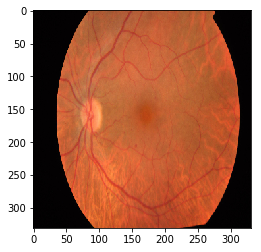

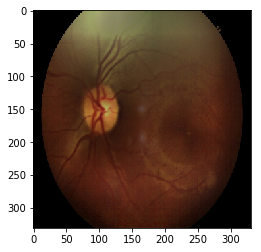

In [12]:
print_gen(d_cls.valid_gen)

## model

In [13]:
# モデル定義
model, orig_model = define_model.get_fine_tuning_model(output_dir
                                                       , img_rows, img_cols, channels
                                                       , len(class_name)
                                                       , choice_model, trainable
                                                       , FCnum=FCnum
                                                       , activation=activation
                                                       , efficientnet_num=efficientnet_num
                                                      )
# compile the model
optim = define_model.get_optimizers(choice_optim=choice_optim, lr=lr, momentum=momentum, nesterov=True)#, decay=decay)
model.compile(loss='categorical_crossentropy'
              , optimizer=optim
              , metrics=['acc'])

# finetunning用にレイヤーの数と名前を表示
count= 0
for layer in model.layers:
    print(count, layer.name, layer.trainable)
    count+=1
keras.utils.plot_model(model, to_file=os.path.join(output_dir, 'model.svg'), show_shapes=True)

model.summary()

----- model_param -----
output_dir = D:\work\kaggle_aptos2019-blindness-detection\work\20190731
img_rows img_cols channels = 331 331 3
num_classes = 5
choice_model trainable = EfficientNet all
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
EfficientNetB5
input_shape: (331, 331, 3)
----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
0 input_1 True
1 conv2d_1 True
2 batch_normalization_1 True
3 swish_1 True
4 depthwise_conv2d_1 True
5 batch_normalization_2 True
6 swish_2 True
7 lambda_1 True
8 conv2d_2 True
9 swish_3 True
10 conv2d_3 True
11 activation_1 True
12 multiply_1 True
13 conv2d_4 True
14 batch_normalization_3 True
15 depthwise_conv2d_2 True
16 batch_normalization_4 True
17 swish_4 True
18 lambda_2 True
19 conv2d_5 True
20 swish_5 True
21 conv2d_6 True
22 activation_2 True
23 multiply_2 True
24 conv2d_7 True
25 batch_normal

conv2d_3 (Conv2D)               (None, 1, 1, 48)     624         swish_3[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1, 1, 48)     0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 166, 166, 48) 0           activation_1[0][0]               
                                                                 swish_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 166, 166, 24) 1152        multiply_1[0][0]                 
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 166, 166, 24) 96          conv2d_4[0][0]                   
__________

conv2d_23 (Conv2D)              (None, 83, 83, 240)  9600        add_4[0][0]                      
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 83, 83, 240)  960         conv2d_23[0][0]                  
__________________________________________________________________________________________________
swish_17 (Swish)                (None, 83, 83, 240)  0           batch_normalization_17[0][0]     
__________________________________________________________________________________________________
depthwise_conv2d_7 (DepthwiseCo (None, 83, 83, 240)  2160        swish_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 83, 83, 240)  960         depthwise_conv2d_7[0][0]         
__________________________________________________________________________________________________
swish_18 (

__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 42, 42, 384)  24576       add_8[0][0]                      
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 42, 42, 384)  1536        conv2d_43[0][0]                  
__________________________________________________________________________________________________
swish_32 (Swish)                (None, 42, 42, 384)  0           batch_normalization_32[0][0]     
__________________________________________________________________________________________________
depthwise_conv2d_12 (DepthwiseC (None, 42, 42, 384)  9600        swish_32[0][0]                   
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 42, 42, 384)  1536        depthwise_conv2d_12[0][0]        
__________

                                                                 add_11[0][0]                     
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 21, 21, 768)  98304       add_12[0][0]                     
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 21, 21, 768)  3072        conv2d_63[0][0]                  
__________________________________________________________________________________________________
swish_47 (Swish)                (None, 21, 21, 768)  0           batch_normalization_47[0][0]     
__________________________________________________________________________________________________
depthwise_conv2d_17 (DepthwiseC (None, 21, 21, 768)  6912        swish_47[0][0]                   
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 21, 21, 176)  704         conv2d_82[0][0]                  
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 21, 21, 1056) 185856      batch_normalization_61[0][0]     
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 21, 21, 1056) 4224        conv2d_83[0][0]                  
__________________________________________________________________________________________________
swish_62 (Swish)                (None, 21, 21, 1056) 0           batch_normalization_62[0][0]     
__________________________________________________________________________________________________
depthwise_conv2d_22 (DepthwiseC (None, 21, 21, 1056) 26400       swish_62[0][0]                   
__________

conv2d_102 (Conv2D)             (None, 21, 21, 176)  185856      multiply_26[0][0]                
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 21, 21, 176)  704         conv2d_102[0][0]                 
__________________________________________________________________________________________________
drop_connect_21 (DropConnect)   (None, 21, 21, 176)  0           batch_normalization_76[0][0]     
__________________________________________________________________________________________________
add_21 (Add)                    (None, 21, 21, 176)  0           drop_connect_21[0][0]            
                                                                 add_20[0][0]                     
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 21, 21, 1056) 185856      add_21[0][0]                     
__________

__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 11, 11, 304)  554496      multiply_31[0][0]                
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 11, 11, 304)  1216        conv2d_122[0][0]                 
__________________________________________________________________________________________________
drop_connect_25 (DropConnect)   (None, 11, 11, 304)  0           batch_normalization_91[0][0]     
__________________________________________________________________________________________________
add_25 (Add)                    (None, 11, 11, 304)  0           drop_connect_25[0][0]            
                                                                 add_24[0][0]                     
__________________________________________________________________________________________________
conv2d_123

conv2d_141 (Conv2D)             (None, 1, 1, 1824)   140448      swish_106[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 1, 1, 1824)   0           conv2d_141[0][0]                 
__________________________________________________________________________________________________
multiply_36 (Multiply)          (None, 11, 11, 1824) 0           activation_36[0][0]              
                                                                 swish_105[0][0]                  
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 11, 11, 304)  554496      multiply_36[0][0]                
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 11, 11, 304)  1216        conv2d_142[0][0]                 
__________

In [14]:
def get_cb(output_dir, cosine_annealing_num_epoch=None):
    cb = []

    # 学習率をエポック増やすごとにコサインカーブで上げ下げする. epochsはコサインカーブのほぼ半周期になるエポック数
    cb.append(my_callback.cosine_annealing(epochs=num_epoch))

    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'best_val_loss.h5'), monitor='val_loss', save_best_only=True, verbose=1))
    # 各エポックでval_accが最大となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'best_val_acc.h5'), monitor='val_acc', save_best_only=True, verbose=1, mode='max'))

    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping, verbose=1))
    
    return cb

## train

In [15]:
%%time
start_time = time.time()
history = model.fit_generator(
    d_cls.train_gen
    , steps_per_epoch = d_cls.init_train_steps_per_epoch # 1エポックあたりの学習(step)回数
    , epochs = num_epoch # エポック数
    , validation_data = d_cls.valid_gen # 検証ファイル生成
    , validation_steps = d_cls.init_valid_steps_per_epoch # 検証するファイル数
    , verbose = 2# 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    , callbacks = get_cb(output_dir, cosine_annealing_num_epoch=None)
    #, class_weight = class_weight # クラスの不均衡を考慮して、トレーニングデータのclass_weight指定
    )
end_time = time.time()
print("Elapsed Time : {:.2f}sec".format(end_time - start_time))

Epoch 1/500
 - 1583s - loss: 1.4982 - acc: 0.3610 - val_loss: 2.0459 - val_acc: 0.0802

Epoch 00001: val_loss improved from inf to 2.04592, saving model to D:\work\kaggle_aptos2019-blindness-detection\work\20190731\best_val_loss.h5

Epoch 00001: val_acc improved from -inf to 0.08022, saving model to D:\work\kaggle_aptos2019-blindness-detection\work\20190731\best_val_acc.h5
Epoch 2/500
 - 1485s - loss: 1.3894 - acc: 0.4195 - val_loss: 1.5276 - val_acc: 0.2923

Epoch 00002: val_loss improved from 2.04592 to 1.52761, saving model to D:\work\kaggle_aptos2019-blindness-detection\work\20190731\best_val_loss.h5

Epoch 00002: val_acc improved from 0.08022 to 0.29231, saving model to D:\work\kaggle_aptos2019-blindness-detection\work\20190731\best_val_acc.h5
Epoch 3/500
 - 1493s - loss: 1.3321 - acc: 0.4536 - val_loss: 1.3369 - val_acc: 0.5516

Epoch 00003: val_loss improved from 1.52761 to 1.33692, saving model to D:\work\kaggle_aptos2019-blindness-detection\work\20190731\best_val_loss.h5

Epoc

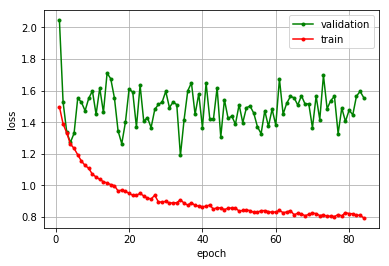

<Figure size 432x288 with 0 Axes>

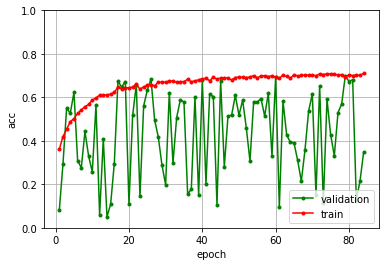

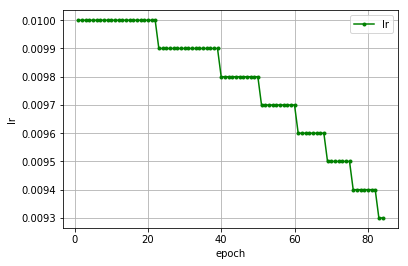

<Figure size 432x288 with 0 Axes>

In [23]:
import os
import matplotlib
#Jupyterでインライン表示するための宣言
%matplotlib inline
plot_log.plot_results(output_dir, os.path.join(output_dir, 'tsv_logger.tsv'))

## validation predict

In [12]:
load_model = keras.models.load_model(os.path.join(output_dir, 'best_val_acc.h5'))

In [13]:
d_cls.valid_gen.filenames = list(map(lambda f: os.path.join(data_dir, f), d_cls.valid_gen.filenames))
d_cls.valid_gen.filenames[:5]

['D:\\work\\kaggle_aptos2019-blindness-detection\\OrigData\\aptos2019-blindness-detection\\train_images\\0024cdab0c1e.png',
 'D:\\work\\kaggle_aptos2019-blindness-detection\\OrigData\\aptos2019-blindness-detection\\train_images\\00cb6555d108.png',
 'D:\\work\\kaggle_aptos2019-blindness-detection\\OrigData\\aptos2019-blindness-detection\\train_images\\00f6c1be5a33.png',
 'D:\\work\\kaggle_aptos2019-blindness-detection\\OrigData\\aptos2019-blindness-detection\\train_images\\0104b032c141.png',
 'D:\\work\\kaggle_aptos2019-blindness-detection\\OrigData\\aptos2019-blindness-detection\\train_images\\0124dffecf29.png']

In [14]:
dir(d_cls.valid_gen)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_params',
 '_filepaths',
 '_filter_classes',
 '_filter_valid_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_sample_weight',
 '_set_index_array',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_indices',
 'class_mode',
 'classes',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'get_classes',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'labels',
 'lock',
 'n',
 'next',
 'on_epoch_end',
 'reset',
 'sample_weight',
 'samples',
 'save_format

In [30]:
class_indices = d_cls.valid_gen.class_indices
print(class_indices)
classes_list = list(class_indices.keys())
print(classes_list)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
['0', '1', '2', '3', '4']


### validation predict

------------------------------------
out_dir: D:\work\kaggle_aptos2019-blindness-detection\work\20190731\prediction\valid
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       451
           1       0.49      0.46      0.48        93
           2       0.73      0.42      0.53       250
           3       0.50      0.15      0.23        48
           4       0.27      0.81      0.40        74

   micro avg       0.70      0.70      0.70       916
   macro avg       0.59      0.56      0.52       916
weighted avg       0.77      0.70      0.71       916

Confusion matrix, without normalization


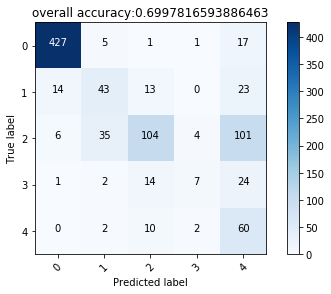

,Filename,PredictionLabel,PredictionScore
0,D:\work\kaggle_aptos2019-blindness-detection\O...,1,0.296
1,D:\work\kaggle_aptos2019-blindness-detection\O...,1,0.262
2,D:\work\kaggle_aptos2019-blindness-detection\O...,0,0.238
3,D:\work\kaggle_aptos2019-blindness-detection\O...,4,0.256
4,D:\work\kaggle_aptos2019-blindness-detection\O...,0,0.247


<Figure size 432x288 with 0 Axes>

In [31]:
# validation set predict

# generatorで全件予測
pred_df = base_predict.pred_classes_generator(load_model, d_cls.valid_gen
                                              , steps=len(d_cls.valid_gen)#d_cls.init_valid_steps_per_epoch+1
                                              , classes_list=classes_list)
# 出力先ディレクトリ
pred_output_dir = os.path.join(output_dir, 'prediction', 'valid')
os.makedirs(pred_output_dir, exist_ok=True)

# 予測結果のデータフレームから混同行列作成
base_predict.conf_matrix_from_pred_classes_generator(pred_df
                                                     , classes_list
                                                     , pred_output_dir
                                                     , y_true_label_np=np.array(d_cls.valid_gen.labels, dtype=str)
                                                     , is_label_print=False)

# 予測結果のデータフレーム出力
pred_df.to_csv(os.path.join(pred_output_dir, 'pred.tsv'), sep='\t')
pred_df.head()

### validation TTA predict

base_predict.py: loaded as module file
------------------------------------
out_dir: D:\work\kaggle_aptos2019-blindness-detection\work\20190731\prediction\valid_TTA
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       451
           1       0.51      0.42      0.46        93
           2       0.76      0.44      0.55       250
           3       0.50      0.08      0.14        48
           4       0.27      0.86      0.41        74

   micro avg       0.71      0.71      0.71       916
   macro avg       0.60      0.55      0.50       916
weighted avg       0.78      0.71      0.71       916

Confusion matrix, without normalization


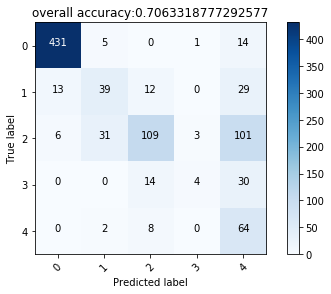

,Filename,PredictionLabel,PredictionScore
0,D:\work\kaggle_aptos2019-blindness-detection\O...,1,0.278
1,D:\work\kaggle_aptos2019-blindness-detection\O...,1,0.249
2,D:\work\kaggle_aptos2019-blindness-detection\O...,0,0.237
3,D:\work\kaggle_aptos2019-blindness-detection\O...,4,0.249
4,D:\work\kaggle_aptos2019-blindness-detection\O...,0,0.228


<Figure size 432x288 with 0 Axes>

In [34]:
# generatorのnextからTTAする場合
# validation set

# TTA
pred_tta = base_predict.predict_tta_generator(load_model
                                              , d_cls.valid_gen
                                              , TTA='flip'
                                              #, TTA_rotate_deg=20
                                              #, TTA_crop_num=4, TTA_crop_size=[70,70]
                                              , resize_size=[img_rows, img_cols])
pred_tta_df = base_predict.get_predict_generator_results(pred_tta
                                                         , d_cls.valid_gen
                                                         , classes_list=classes_list)

# 出力先ディレクトリ
pred_output_dir = os.path.join(output_dir, 'prediction', 'valid_TTA')
os.makedirs(pred_output_dir, exist_ok=True)

# 予測結果のデータフレームから混同行列作成
base_predict.conf_matrix_from_pred_classes_generator(pred_tta_df
                                                     , classes_list
                                                     , pred_output_dir
                                                     , y_true_label_np=np.array(d_cls.valid_gen.labels, dtype=str)
                                                     , is_label_print=False)

# 予測結果のデータフレーム出力
pred_tta_df.to_csv(os.path.join(pred_output_dir, 'pred.tsv'), sep='\t')
pred_tta_df.head()

### validation GradCam++

D:\work\kaggle_aptos2019-blindness-detection\OrigData\aptos2019-blindness-detection\train_images\03c85870824c.png


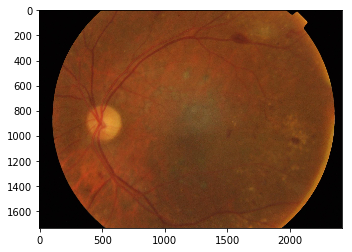

predict_score: [[0.16105446 0.16205832 0.18125321 0.2581299  0.23750415]]
classes: ['0', '1', '2', '3', '4']
max_pred_label:  3
(1, 331, 331, 3)


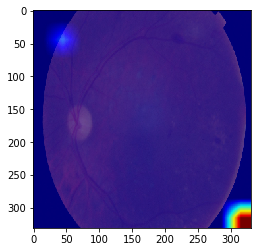

out_jpg: D:\work\kaggle_aptos2019-blindness-detection\work\20190731\gradcam\FN\train_images_03c85870824c.png_pred_3_0.26.jpg
--------------------------------------------
D:\work\kaggle_aptos2019-blindness-detection\OrigData\aptos2019-blindness-detection\train_images\054b1b305160.png


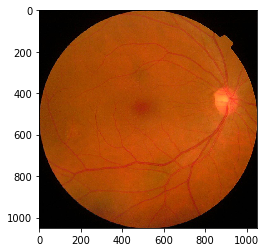

predict_score: [[0.28407037 0.15231496 0.1761376  0.16855018 0.21892686]]
classes: ['0', '1', '2', '3', '4']
max_pred_label:  0
(1, 331, 331, 3)


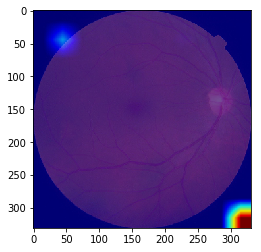

out_jpg: D:\work\kaggle_aptos2019-blindness-detection\work\20190731\gradcam\FN\train_images_054b1b305160.png_pred_0_0.28.jpg


In [40]:
# 入力画像のファイルパス
data_paths = glob.glob(data_dir+'/**', recursive=True)

# 画像1件のファイルパスからgradcam実行+ファイル出力
grad_cam_img = grad_cam_util.gradcam_from_img_path(load_model
                                                   , data_paths[50]
                                                   , output_dir
                                                   , classes_list
                                                   , img_rows, img_cols
                                                   , layer_name=layer_name
                                                   , is_gradcam_plus=True)
print('--------------------------------------------')
grad_cam_img = grad_cam_util.gradcam_from_img_path(load_model
                                                   , data_paths[70]
                                                   , output_dir
                                                   , classes_list
                                                   , img_rows, img_cols
                                                   , layer_name=layer_name
                                                   , is_gradcam_plus=True)

In [38]:
display(raw_train_df[raw_train_df['id_code'] == '03c85870824c'])
display(valid_df[valid_df['x_paths'] == '03c85870824c.png'])
print()
display(raw_train_df[raw_train_df['id_code'] == '054b1b305160'])
display(valid_df[valid_df['x_paths'] == '054b1b305160.png'])

,id_code,diagnosis,path,exists
49,03c85870824c,3,D:\work\kaggle_aptos2019-blindness-detection\O...,True


,x_paths,y_ids


,id_code,diagnosis,path,exists
69,054b1b305160,0,D:\work\kaggle_aptos2019-blindness-detection\O...,True


,x_paths,y_ids


### ROC図

In [ ]:
#from sklearn.metrics import roc_curve, roc_auc_score
#sick_vec = d_cls.valid_gen.labels>0
#pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
#sick_score = np.sum(pred_Y[:,1:],1)
#fpr, tpr, _ = roc_curve(sick_vec, sick_score)
#fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
#ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
#ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
#ax1.legend()
#ax1.set_xlabel('False Positive Rate')
#ax1.set_ylabel('True Positive Rate');

## test TTA predict

In [35]:
load_model = keras.models.load_model(os.path.join(output_dir, 'best_val_acc.h5'))

In [36]:
img_paths = util.find_img_files(base_image_dir+'/test_images')

# 指定のファイルパス全件 predict_tta() で予測実行
pred_df = base_predict.pred_tta_from_paths(load_model, img_paths, img_rows, img_cols
                                           , classes=None, show_img=False
                                           , TTA='flip'
                                           #, TTA_rotate_deg=0
                                           #, TTA_crop_num=0, TTA_crop_size=[224, 224]
                                           , preprocess=1.0/255.0)

Processing D:\work\kaggle_aptos2019-blindness-detection\OrigData\aptos2019-blindness-detection/test_images\ffdc2152d455.png: 100%|█| 1928/1928 [04:18<00:00,  7.25it/s]


In [49]:
display(pred_df.head(10))

,Filename,PredictionLabel,PredictionScore
0,D:\work\kaggle_aptos2019-blindness-detection\O...,1,0.281276
1,D:\work\kaggle_aptos2019-blindness-detection\O...,2,0.250278
2,D:\work\kaggle_aptos2019-blindness-detection\O...,4,0.248095
3,D:\work\kaggle_aptos2019-blindness-detection\O...,4,0.244338
4,D:\work\kaggle_aptos2019-blindness-detection\O...,1,0.264711
5,D:\work\kaggle_aptos2019-blindness-detection\O...,4,0.237243
6,D:\work\kaggle_aptos2019-blindness-detection\O...,2,0.238383
7,D:\work\kaggle_aptos2019-blindness-detection\O...,0,0.281701
8,D:\work\kaggle_aptos2019-blindness-detection\O...,3,0.263105
9,D:\work\kaggle_aptos2019-blindness-detection\O...,0,0.401438


### 提出データ作成

In [44]:
submit_df = pd.DataFrame({'id_code': list(map(lambda p: pathlib.Path(p).stem, pred_df['Filename']))
                          , 'diagnosis': pred_df['PredictionLabel']})
submit_df.to_csv(output_dir+'/submission_20190731.csv', index=False)
display(submit_df.head(10))

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,4
3,00836aaacf06,4
4,009245722fa4,1
5,009c019a7309,4
6,010d915e229a,2
7,0111b949947e,0
8,01499815e469,3
9,0167076e7089,0


In [ ]:
print(submit_df['diagnosis'].value_counts())
#submit_df['diagnosis'].hist(figsize=(10, 5))